In [95]:
import skimage                                                          
import imageio                                                          
import numpy as np
import scipy.signal
import scipy.optimize

BACKGROUND_THRESHOLD=15                                                 
MEAN_SPOT_PEAK_FRACTION=0.25
BOX_THRESHOLD = 100 # For binarization of lenslet. TODO: what should threshold be?
FPS=7 # TODO: get from input file

filename='../stack.avi_reg.avi';
output_filename='../stack_centered.avi'

vid = imageio.get_reader(filename, 'ffmpeg')                            
                                                                        
nframe=0                                                                
frames=[]                                                               
for image in vid.iter_data():                                           
    data=np.mean(image,2)                                               
    frames += [data]                                                    
    #print(image.mean(),nframe)                                          
    nframe +=1                                                          
frames=np.array( frames)                                                
                                                                        
# Initial background threshold                                          
frames[frames<BACKGROUND_THRESHOLD]=0                                   
                                                                        
coord_max=np.unravel_index( np.argmax( frames[1] ), frames[1].shape ) # y,x

meansigX=np.mean( np.mean( frames, 0), 0 )
meansigY=np.mean( np.mean( frames, 0), 1 )
#peaks2=scipy.signal.find_peaks(xsig, distance=30, height=10)[0]


# Guess lenslet spacing by taking the average x dist and average y distance between brightest spots
peaksX=scipy.signal.find_peaks(meansigX, distance=30, height=meansigX.max()*MEAN_SPOT_PEAK_FRACTION)[0]
peaksY=scipy.signal.find_peaks(meansigY, distance=30, height=meansigY.max()*MEAN_SPOT_PEAK_FRACTION)[0]
spacing = np.mean( [np.mean( np.diff(peaksX)), np.mean(np.diff(peaksY))] )

corners_x=np.arange( int( frames[0].shape[1]//spacing ) ) * spacing
corners_y=np.arange( int( frames[0].shape[0]//spacing ) ) * spacing

# Find the brightest pixel across all frames. Assume it's a good spot (shift phase of spot array)
coordsA=np.unravel_index( np.argmax( np.mean(frames,0) ), frames[0].shape )

corners_x = np.array( corners_x + coordsA[1] % spacing - spacing//2 , dtype='int')
corners_y = np.array( corners_y + coordsA[0] % spacing - spacing//2 , dtype='int')

boxes_all = np.zeros( (frames.shape[0],corners_y.size, corners_x.size))

opts_all=np.zeros( (frames.shape[0],3) )

stride=int( np.ceil(spacing) )
box1=np.ones( (stride,stride) )

box_sums = np.zeros( (corners_y.size, corners_x.size) )

X,Y=np.meshgrid( np.arange(box_sums.shape[1]), np.arange(box_sums.shape[0]) )

def circle(cx,cy,rad):
    X,Y=np.meshgrid( np.arange(box_sums.shape[1]), np.arange(box_sums.shape[0]) )
    r=np.sqrt((X-cx-0.0*np.sign(X))**2+(Y-cy-0.0*np.sign(Y))**2) # 0.5 fudge
    #r=np.sqrt((X-cx)**2+(Y-cy)**2)
    #rad=7.27 # IGNORE RADIUS. Fixed pupil size
    result=(r<rad)*1.0
    return result

def circle_err(p):
    ssq=np.sum( (circle(*p)-desired) **2 )
    #print( p, ssq)
    return ssq

for nframe in np.arange(frames.shape[0]):

    #convs=scipy.signal.convolve2d( frames[nframe], box1)

    for nx,x in enumerate(corners_x):
        for ny,y in enumerate(corners_y):
            box_sums[ny,nx]=np.sum( frames[nframe,y:y+stride,x:x+stride] )
            #box_sums[ny,nx]=convs[int(y+spacing),int(x+spacing)] # extract from convs
            box1=frames[nframe,y:y+stride,x:x+stride]
            #if box1.size>0:
            #    box_sums[ny,nx]=np.max( box1 )
            #else:
            #    box_sums[ny,nx]=0
            
    boxes_all[nframe]=box_sums

    desired = (box_sums > BOX_THRESHOLD)*1.0 # binarize 

    guess =[ np.sum( desired*X / np.sum(desired ) ) ,
            np.sum( desired*Y / np.sum(desired ) ),
            np.sqrt( np.sum(desired) / np. pi ) ]

    opt1=scipy.optimize.minimize( circle_err, guess, method='Nelder-Mead')
    #print(nframe,opt1)     
    
    opts_all[nframe]=opt1.x
    
# WRITE DATA
middle_box=np.array(np.round( np.array(frames[0].shape) / stride / 2), dtype='int' )

vid_out = imageio.get_writer(output_filename, 'ffmpeg',fps=FPS, quality=10, codec='rawvideo', pixelformat="pal8")

outframes=frames*0

for nframe,frame1 in enumerate(frames):
    opts1=opts_all[nframe]
    opts1r=np.array(np.round(opts1),dtype='int') # Round to nearest (for center, mainly)
    
    deltay=middle_box[0]-opts1r[1] # Y coord. opts is (x,y)
    deltax=middle_box[1]-opts1r[0] # X coord
    
    frame1x = np.array( frame1, dtype='uint8')
    frame1x = np.roll(frame1x,deltay*stride,0) # Y axis 
    frame1x = np.roll(frame1x,deltax*stride,1) # X axis
    
    outframes[nframe]=frame1x
    
    data_rgb=np.stack([frame1x] * 3, axis=-1)
    vid_out.append_data(data_rgb)

vid_out.close()
print("Ok")

Ok


In [78]:
output_filename

'../stack_centered.avi'

In [98]:
output_filename="../stack_centered3.avi"

In [109]:
# vid_out = imageio.get_writer(output_filename, codec='mjpeg',fps=FPS, quality=10)
#vid_out = imageio.get_writer(output_filename, 'ffmpeg',fps=FPS, quality=10, codec='rawvideo', pixelformat="pal8")

vid_out = imageio.get_writer(output_filename, fps=FPS, codec='rawvideo', pixelformat="gray")

outframes=frames*0

for nframe,frame1 in enumerate(frames):
    opts1=opts_all[nframe]
    opts1r=np.array(np.round(opts1),dtype='int') # Round to nearest (for center, mainly)
    
    deltay=middle_box[0]-opts1r[1] # Y coord. opts is (x,y)
    deltax=middle_box[1]-opts1r[0] # X coord
    
    frame1x = np.array( frame1, dtype='uint8')
    frame1x = np.roll(frame1x,deltay*stride,0) # Y axis 
    frame1x = np.roll(frame1x,deltax*stride,1) # X axis
    
    outframes[nframe]=frame1x
    
    #data_rgb=np.stack([frame1x], axis=-1)
    vid_out.append_data(data_rgb)

vid_out.close()
print("Ok")

Ok


In [1]:
import opencv as cv2
% fourcc = cv2.VideoWriter_fourcc(*'RGBA')

ModuleNotFoundError: No module named 'opencv'

In [2]:
plt.figure; plt.imshow(frame1x)

NameError: name 'plt' is not defined

(-0.5, 21.5, 17.5, -0.5)

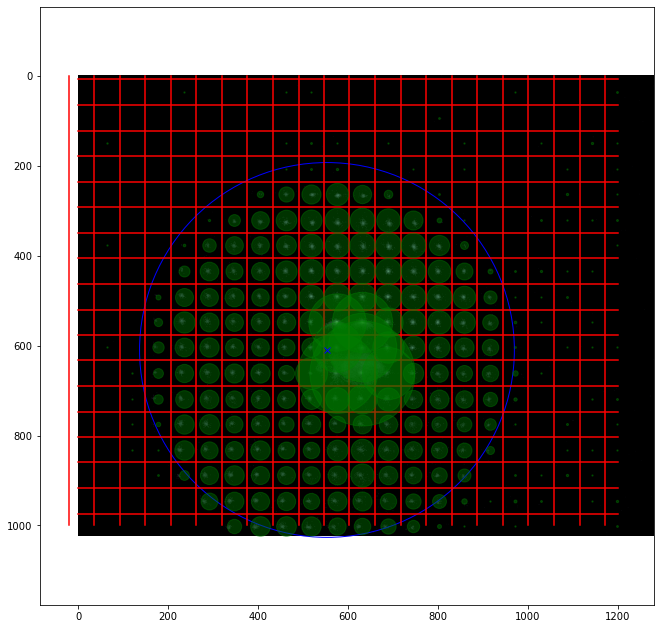

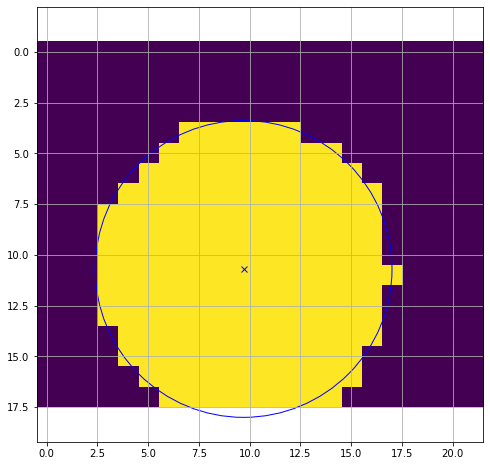

In [46]:
frame_show=16

plt.figure(figsize=(11,11))
plt.imshow( frames[frame_show], cmap='bone')

#plt.scatter( coordsA[1], coordsA[0], s=3, color='r') # x,y

for ncorner,xc1 in enumerate(corners_x):
    plt.plot( [xc1,xc1], [0,1000], 'r-')
    
for ncorner,yc1 in enumerate(corners_y):
    plt.plot( [0,1200], [yc1,yc1], 'r-')
    
for nx,x in enumerate(corners_x):
    for ny,y in enumerate(corners_y):
        plt.plot(x+spacing//2,y+spacing//2, 'go', ms=np.sqrt(boxes_all[frame_show,ny,nx])/3, alpha=0.4 )


import matplotlib.patches as mpatches   
opt1=opts_all[frame_show]
cx_pix,cy_pix=(opt1[0]*stride, opt1[1]*stride)
circ=mpatches.Circle( (cx_pix, cy_pix), opt1[2]*stride, color="none",ec='blue')
ax=plt.gca()
ax.add_artist(circ)

plt.plot( cx_pix, cy_pix, 'bx' )
plt.axis('equal')

plt.figure(figsize=(8,8))
plt.imshow(boxes_all[frame_show]>BOX_THRESHOLD)
circ=mpatches.Circle( (opt1[0], opt1[1]), opt1[2], color="none",ec='blue')
ax=plt.gca()
ax.add_artist(circ)
plt.plot( opt1[0], opt1[1], 'bx' )
plt.grid()
plt.axis('equal')

In [60]:
print (f"Ok. Wrote {frames.shape[0]} frames to {output_filename}" )

Ok. Wrote 27 frames to ../stack_centered.avi
